In [1]:
import pickle
import itertools
import open3d as o3d
import numpy as np
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from scipy import interpolate
from scipy import ndimage

In [3]:
import sklearn
from sklearn.decomposition import PCA
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist


In [4]:
with open("curves_by/q_curves/112_b20_s45_lmin40_lmax_100_o15_q_10.curves", "rb") as pickle_file:
    curve_fragment = pickle.load(pickle_file)

In [5]:
cfs = [[],[],[],[],[],[],[],[]]
for cols in curve_fragment:
    for i in range(len(cols)):
        if i == 0:
            cfs[0] += cols[i]
        if i == 1:
            cfs[1] += cols[i]
        if i == 2:
            cfs[2] += cols[i]
        if i == 3:
            cfs[3] += cols[i]
        if i == 4:
            cfs[4] += cols[i]
        if i == 5:
            cfs[5] += cols[i]
        if i == 6:
            cfs[6] += cols[i]
        if i == 7:
            cfs[7] += cols[i]

In [6]:
from scipy import interpolate
color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)

_cfs = []

for i in range(len(cfs)):
    color_cfs = []
    for j, frag in enumerate(cfs[i]):
        if frag.size == 0:
            continue
        if j % 50 != 0:
            continue
        #print(frag)
        x = frag[:,0]
        y = frag[:,1]
        z = frag[:,2]
        data = [x,y,z]
        try:
            tck, u= interpolate.splprep(data, k=3)
        except ValueError:
            pass
        except TypeError:
            pass
        new = interpolate.splev(u, tck, der=0)
        c = color_arr[i]/255
        
        color_cfs.append(np.array([new[0], new[1], new[2]]).transpose(1,0))
    _cfs.append(color_cfs)

In [7]:
def clustering(cfs_part):
    flatten_curve_frag = np.array(list(itertools.chain.from_iterable(cfs_part)))
    pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)
    labels = np.array(pcd.cluster_dbscan(eps=0.005, min_points=10))
    unique, freq = np.unique(labels, return_counts=True)
    mode = unique[np.argmax(freq)]
    flatten_curve_frag = flatten_curve_frag[labels==mode]
    return flatten_curve_frag
    
def same_checker(ls):
    for i, num1 in enumerate(ls):
        for j, num2 in enumerate(ls):
            if i == j:
                continue
            if np.abs(num1 - num2) <0.0005:
                return num1

def sort_cluster(cluster):
    pca = PCA()
    pca.fit(cluster)
    feature = pca.transform(cluster)

    r = (feature[:, 0]**2 + feature[:, 1]**2)**(1/2)
    cos = feature[:, 0]/r
    sin = feature[:, 1]/r

    arccos = np.arccos(cos)
    arcsin = np.arcsin(sin)
    arccos_m = -arccos
    arcsin_m = -np.pi -arcsin
    arcsin_p = np.pi - arcsin
    
    feature_theta = []
    for temp_list in zip(arccos, arcsin, arccos_m, arcsin_m, arcsin_p):
        theta = same_checker(temp_list)
        feature_theta.append(theta)
    feature_theta = np.array(feature_theta)
    
    cluster_ex_nan = cluster[np.where(feature_theta != None)]
    feature_theta_ex_nan = feature_theta[np.where(feature_theta != None)]
    sorted_idx = np.argsort(feature_theta_ex_nan)
    sorted_cluster = cluster_ex_nan[sorted_idx]
    return sorted_cluster

def outlier_removal(sorted_cluster):
    x = sorted_cluster[:,0]
    y = sorted_cluster[:,2]
    z = sorted_cluster[:,1]
    data = [x,y,z]

    jump = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2) 
    smooth_jump = ndimage.gaussian_filter1d(jump, 5, mode='wrap')  # window of size 5 is arbitrary
    limit = 2*np.median(smooth_jump)    # factor 2 is arbitrary
    xn, yn, zn = x[:-1], y[:-1], z[:-1]
    xn = xn[(jump > 0) & (smooth_jump < limit)]
    yn = yn[(jump > 0) & (smooth_jump < limit)]
    zn = zn[(jump > 0) & (smooth_jump < limit)]

    data = [xn,yn,zn]
    return data

def organize_data(flatten_curve_frag):
    sorted_cluster = sort_cluster(flatten_curve_frag)
    data = outlier_removal(sorted_cluster)
    return data

In [8]:
pcd = o3d.geometry.PointCloud()
data_list = []
for i in range(len(_cfs)):
    flatten_curve_frag = np.array(list(itertools.chain.from_iterable(_cfs[i])))
    pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)
    labels = np.array(pcd.cluster_dbscan(eps=0.005, min_points=10))
    unique, freq = np.unique(labels, return_counts=True)
    mode = unique[np.argmax(freq)]
    flatten_curve_frag = flatten_curve_frag[labels==mode]
    data = organize_data(flatten_curve_frag)
    data_list.append(data)

In [9]:
#data_list = organize_data(_cfs)

In [10]:
# 赤，緑，青，黄，ピンク，水，灰，紫
q_1_h_list = np.array([0.13, 0.12, 0.12, 0.11, 0.18, 0.14, 0.11, 0.21])
q_2_h_list = np.array([0.14, 0.17, 0.13, 0.09, 0.15, 0.17, 0.12, 0.2])
q_3_h_list = np.array([0.14, 0.17, 0.13, 0.13, 0.11, 0.14, 0.12, 0.17])
q_4_h_list = np.array([0.18, 0.17, 0.13, 0.23, 0.17, 0.19, 0.12, 0.2])
q_5_h_list = np.array([0.18, 0.2, 0.17, 0.12, 0.17, 0.25, 0.12, 0.16])

q_6_h_list = np.array([0.18, 0.2, 0.17, 0.12, 0.17, 0.25, 0.12, 0.16])
q_7_h_list = np.array([0.13, 0.4, 0.17, 0.12, 0.17, 0.2, 0.12, 0.22])
q_8_h_list = np.array([0.22, 0.2, 0.13, 0.23, 0.17, 0.19, 0.12, 0.2])
q_9_h_list = np.array([0.32, 0.14, 0.13, 0.24, 0.25, 0.19, 0.12, 0.17])
q_10_h_list = np.array([0.11, 0.14, 0.17, 0.18, 0.14, 0.21, 0.15, 0.16])

In [11]:
s_curve_list = []
pcd = o3d.geometry.PointCloud()
for i in range(len(data_list)):
    div_num = int(np.round(data_list[i][0].size/10000))
    data = [data_list[i][0][::div_num], data_list[i][1][::div_num], data_list[i][2][::div_num]]
    tck, u = interpolate.splprep(data, s=q_10_h_list[i], k=3, per=1)
    new = interpolate.splev(u, tck, der=0)
    prossed_data = np.array(new)
    smooth_curve = np.stack([prossed_data[0],prossed_data[1],prossed_data[2]],axis=1)
    s_curve_list.append(smooth_curve)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][10429]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][10429]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][10429]=x[2][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][13033]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][13033]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][13033]=x[2][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_f

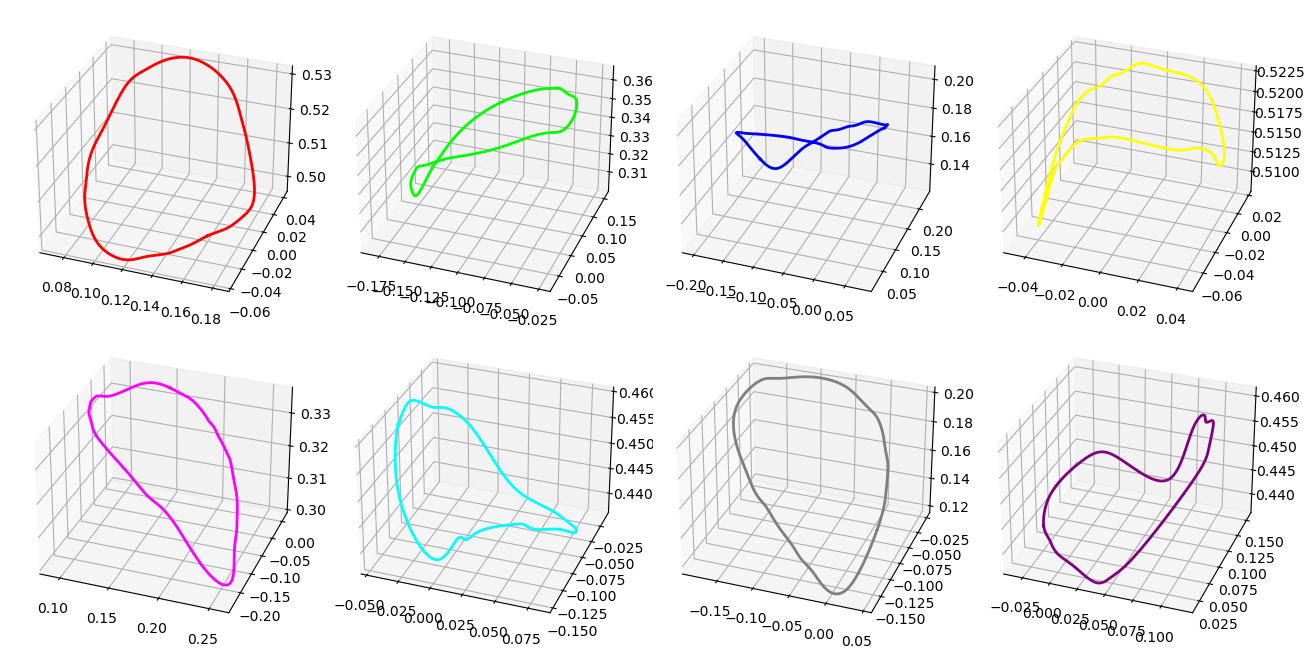

In [12]:
%matplotlib inline
fig = plt.figure(figsize = (13, 13))
fig.patch.set_alpha(0.)
# 3DAxesを追加

c_list = ["#FF0000","#00FF00","#0000FF","#FFFF00","#FF00FF","#00FFFF","#7F7F7F","#7F007F"]

ax1 = fig.add_subplot(441, projection='3d')
ax2 = fig.add_subplot(442, projection='3d')
ax3 = fig.add_subplot(443, projection='3d')
ax4 = fig.add_subplot(444, projection='3d')
ax5 = fig.add_subplot(445, projection='3d')
ax6 = fig.add_subplot(446, projection='3d')
ax7 = fig.add_subplot(447, projection='3d')
ax8 = fig.add_subplot(448, projection='3d')

ax_list = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
# 軸ラベルを設定
for i in range(8):
    x, y, z = s_curve_list[i][:,0], s_curve_list[i][:,1], s_curve_list[i][:,2]
    ax_list[i].plot(x, y, z,"-",c=c_list[i],linewidth = 2.0)
    ax_list[i].view_init(elev=30, azim=-70)

fig.tight_layout()
plt.show()

In [13]:
mesh = o3d.io.read_triangle_mesh("polygon/quan/q_10.ply")
edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)

In [14]:
def edges_to_lineset(mesh, edges, color):
    ls = o3d.geometry.LineSet()
    ls.points = mesh.vertices
    ls.lines = edges
    colors = np.empty((np.asarray(edges).shape[0], 3))
    colors[:] = color
    ls.colors = o3d.utility.Vector3dVector(colors)
    return ls

def rotation_mat(angle):
    Rx = np.array([[1,0,0],
                 [0, np.cos(angle[0]), -np.sin(angle[0])],
                 [0, np.sin(angle[0]), np.cos(angle[0])]])

    Ry = np.array([[np.cos(angle[1]), 0, np.sin(angle[1])],
                 [0,1,0],
                 [-np.sin(angle[1]), 0, np.cos(angle[1])]])

    Rz = np.array([[np.cos(angle[2]), -np.sin(angle[2]), 0],
                 [np.sin(angle[2]), np.cos(angle[2]), 0],
                 [0,0,1]])
    return Rz@Rx@Ry

In [15]:
geoms = [mesh]
geoms.append(edges_to_lineset(mesh, edges, (1, 0, 0)))

In [16]:
angle = [np.pi, np.pi, 0] # pcd.rotate()
#angle = [-np.pi/2, np.pi/2, np.pi/2]
R = rotation_mat(angle)
R_mirror = np.array([[-1,0,0],
                    [0,1,0],
                    [0,0,1]])

In [17]:
geo = []

for j, l_c in enumerate(s_curve_list):
    points = l_c
    lines = [[i,i+1] for i in range(len(points)-1)]
    colors = [color_arr[j]/255 for i in range(len(lines))]
    #print(len(points),len(lines),len(colors))

    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)
    line_set.rotate(np.linalg.inv(R),(0,0,0))
    line_set.scale(10,(0,0,0))
    geo.append(line_set)

#o3d.visualization.draw_geometries(geo)
geo.append(mesh)
#geo.append(edges_to_lineset(mesh, edges, (1, 0, 0)))
o3d.visualization.draw_geometries(geo)

In [615]:
import pickle
with open("curves_by/q_curves/s_112_b20_s45_lmin40_lmax_100_o15_q_10.curves","wb") as f:
    pickle.dump(s_curve_list, f)

In [20]:
def get_com(mesh, edges):
    vertices = np.asarray(mesh.vertices)
    edges = np.asarray(edges)

    for i in range(len(vertices[edges])):
        start = vertices[edges][i][0]
        end = vertices[edges][i][1]

        _com = end + np.repeat(np.arange(51),3).reshape((51,3)) * (start - end)/50

        if i == 0:
            com = np.copy(_com)
            continue
        com = np.concatenate([com, _com])
    return com


In [24]:
with open("curves_by/q_curves/s_112_b20_s55_lmin40_lmax_100_o15_q_3.curves", "rb") as pickle_file:
    s_curve_list = pickle.load(pickle_file)

In [29]:
mesh = o3d.io.read_triangle_mesh("polygon/quan/q_3.ply")
y_emd = []
x_area = []
for i in range(np.max(np.asarray(mesh.cluster_connected_triangles()[0]))+1):
    mesh = o3d.io.read_triangle_mesh("polygon/quan/q_3.ply")
    mesh.triangles = o3d.utility.Vector3iVector(np.asarray(mesh.triangles)[np.asarray(mesh.cluster_connected_triangles()[0])==i])

    _, _, area = mesh.cluster_connected_triangles()
    edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)
    com = get_com(mesh, edges)
    emd_list = []
    for j in range(8):
        x1 = s_curve_list[j][::50]
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(x1)
        pcd.rotate(np.linalg.inv(R),(0,0,0))
        pcd.scale(10,(0,0,0))
        x1 = np.asarray(pcd.points)

        x2 = com

        d = cdist(x1, x2)
        assignment = linear_sum_assignment(d)
        emd = d[assignment].sum() / x1.shape[0]
        emd_list.append(emd)
        
    emd = np.min(emd_list)
    y_emd.append(emd)
    x_area.append(area[0])

In [30]:
y_emd

[0.014752643832283752,
 0.011121822577318051,
 0.012742908870955435,
 0.013913622549033495,
 0.011645985416516538,
 0.016910424959961454,
 0.014047393206301577,
 0.01345730983722171]

In [31]:
np.savetxt('emd_csv/q_csv/q_3_area.csv', x_area, delimiter=',')
np.savetxt('emd_csv/q_csv/q_3_emd.csv', y_emd, delimiter=',')